In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pathlib


print(tf.__version__)

2.12.0


In [ ]:
data_path = "/content/drive/MyDrive/Dataset_resized"
data_dir = pathlib.Path(data_path).with_suffix('')

print([x for x in data_dir.iterdir() if x.is_dir()])

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

[PosixPath('/content/drive/MyDrive/Dataset_resized/snils'), PosixPath('/content/drive/MyDrive/Dataset_resized/employment_record'), PosixPath('/content/drive/MyDrive/Dataset_resized/Birth_certificate'), PosixPath('/content/drive/MyDrive/Dataset_resized/passport'), PosixPath('/content/drive/MyDrive/Dataset_resized/marriage_certificate'), PosixPath('/content/drive/MyDrive/Dataset_resized/Military_ticket'), PosixPath('/content/drive/MyDrive/Dataset_resized/Employment_contract'), PosixPath('/content/drive/MyDrive/Dataset_resized/Pisnoe')]
185


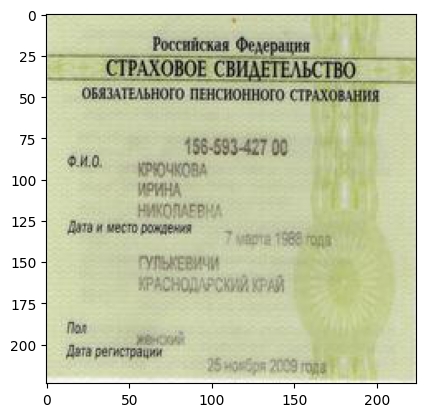

In [ ]:
snils = list(data_dir.glob('snils/*'))
with PIL.Image.open(str(snils[7])) as img:
  plt.imshow(img)

dtype of tensor: <dtype: 'float32'>, shape of tensor: (578, 844, 3)
dtype of resized tensor: <dtype: 'float32'>, shape of resized tensor: (224, 224, 3)


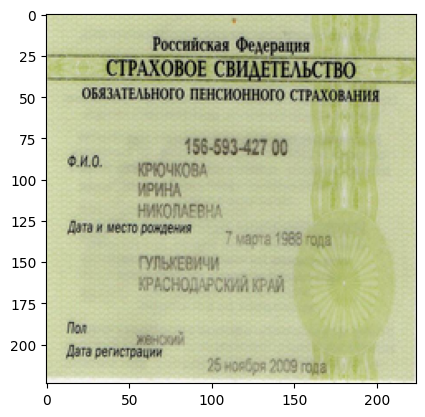

In [ ]:
# resizing dataset's image without paddings to 224x224 for passing in convNN model
# for this stage it seems that LANCZOS3 + antialias is the best

with PIL.Image.open(snils[5]) as snils_example:
  snils_example_tensor = tf.image.convert_image_dtype(snils_example, tf.float32)
  snils_example_tensor = tf.convert_to_tensor(snils_example_tensor)
  print(f"dtype of tensor: {snils_example_tensor.dtype}, shape of tensor: {snils_example_tensor.shape}")

  snils_example_resized = tf.image.resize(snils_example_tensor,
                                        size=[224,224],
                                        method=tf.image.ResizeMethod.LANCZOS3,
                                        antialias=True)

  print(f"dtype of resized tensor: {snils_example_resized.dtype}, shape of resized tensor: {snils_example_resized.shape}")
  plt.imshow(snils_example_resized)

In [ ]:
# convert all images with these resize params and save them
# [x for x in data_dir.iterdir() if x.is_dir()]

unable_to_resize_images = []

def resize_dataset_224(data_dir):
  '''
  applies resize_image_224 to all images in dataset,
  which structure is dataset_name -> class1, class2, ..
  '''
  for folder in data_dir.iterdir():
    if folder.is_dir():
      assert isinstance(folder, pathlib.Path)
      images = folder.glob('*.jpg')
      for image in images:
        resize_image_224(image)

def resize_image_224(img_path):
  '''
  rewriting original image with resized one
  '''
  assert isinstance(img_path, pathlib.Path)
  with PIL.Image.open(img_path) as img:
    img = tf.image.convert_image_dtype(img, tf.float32)
    img_tensor = tf.convert_to_tensor(img)

    # Lanczos3 + antialias
    try:
      img_tensor_resized = tf.image.resize(img_tensor,
                                          size=[224,224],
                                          method=tf.image.ResizeMethod.LANCZOS3,
                                          antialias=True)
    except:
      img_path_parts = pathlib.PurePath(img_path).parts[-2:]
      print(f'{img_path_parts} cant be resized, delete it.')
      unable_to_resize_images.append(img_path_parts)
      return

    pil_img = tf.keras.preprocessing.image.array_to_img(img_tensor_resized)
    pil_img.save(img_path)

In [ ]:
resize_dataset_224(data_dir)

('passport', '21.jpg') cant be resized, delete it.
('employment_record', '4.jpg') cant be resized, delete it.
('employment_record', '1.jpg') cant be resized, delete it.


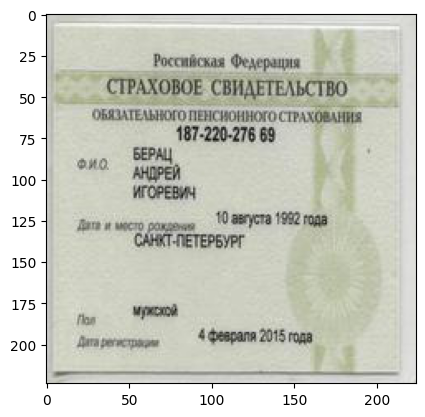

In [ ]:
with PIL.Image.open(snils[10]) as snils_example:
  plt.imshow(snils_example)

In [ ]:
# Now, when img dataset is ready for passing to model, create text dataset with same structure as img dataset
# I'll use TesseractOCR for now

!sudo apt install tesseract-ocr
!sudo apt install tesseract-ocr-rus
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 15 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 1s (4,770 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/Fro

In [ ]:
import pytesseract
import shutil
import os
import random

Founded text:     
 
  
 

дни р ан

_ 057 о -028- 27

ФИ. О. _ БЕЗНОСОВА
ГАЛИНА
ВЛАДИМИРОВНА .

Дата и место рождения 09 декабря

ВЛАДИМИРОВКА.
ТАНДИНСКИЙ
_ТУВИНСКАЯ АССР.

Пол Женский



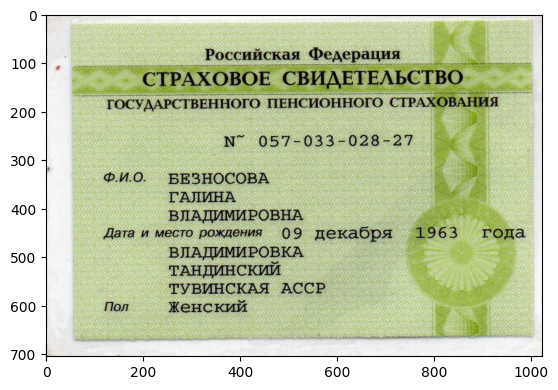

In [ ]:
# psm 11 Sparse text. Find as much text as possible in no particular order.
# psm 12 Sparse text with OSD.
original_ds_path = '/content/drive/MyDrive/Dataset_copy'
original_ds_dir = pathlib.Path(original_ds_path).with_suffix('')
snils = list(original_ds_dir.glob('snils/*.jpg'))

image_example = None
for folder_ex in original_ds_dir.glob('*'):
  for image in folder_ex.glob('*.jpg'):
    # checking how iteration works while hardcoding some example
    if image == pathlib.Path('/content/drive/MyDrive/Dataset_copy/snils/3.jpg'):
      image_example = image

with PIL.Image.open(image_example) as img:
  plt.imshow(img)
  img_text = pytesseract.image_to_string(img,
                                         config='--psm 3 -c tessedit_char_blacklist= ‘][|/`',
                                         lang='rus')
  print(f'Founded text: {img_text}')

In [ ]:
# TODO: If I'll have a lot of time, I can also try using PaddleOCR instead of Tesseract
# Tutorial and proper models:
# https://medium.com/@anhtuan_40207/tutorial-ocr-with-paddleocr-pp-ocr-9a4342e4d7f
# https://paddleocr.bj.bcebos.com/PP-OCRv3/multilingual/Multilingual_PP-OCRv3_det_infer.tar
# https://paddleocr.bj.bcebos.com/PP-OCRv3/multilingual/cyrillic_PP-OCRv3_rec_infer.tar
# https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_slim_infer.tar

!python -m pip install paddlepaddle -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install "paddleocr>=2.0.1" # Recommend to use version 2.0.1+

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [ ]:
# recreating dataset structure

def create_text_ds_structure(ds_name):
  # creating root folder
  text_data_dir = f'/content/drive/MyDrive/{ds_name}'
  if not os.path.exists(text_data_dir):
    os.makedirs(text_data_dir)

  # getting names of class folders
  class_folders = [str(x).split('/')[-1] for x in original_ds_dir.iterdir() if x.is_dir()]
  # creating class folders in root folder
  for class_folder in class_folders:
    class_folder_path = os.path.join(text_data_dir, class_folder)
    if not os.path.exists(class_folder_path):
      os.makedirs(class_folder_path)



In [ ]:
text_ds_name = 'Dataset_text'
create_text_ds_structure(text_ds_name)

In [ ]:
# parsing each image from images ds and saving results in new text ds
# some examples somewhy can't be scanned with tesseract, i'll find and delete them
# (actually only one example)


original_ds_dir = pathlib.Path('/content/drive/MyDrive/Dataset_copy')
text_ds_path = f'/content/drive/MyDrive/{text_ds_name}'
text_ds_dir = pathlib.Path(text_ds_path).with_suffix('')

def generate_text_dataset(image_source_ds, output_ds_folder):
  '''
  parsing each image from images ds and saving results in new text ds
  structure of the datasets has to be the same
  '''
  c = 1
  for class_folder in image_source_ds.glob('*'):
    for image in class_folder.glob('*.jpg'):
      with PIL.Image.open(image) as img:
        # creating image path with changing jpg extension to txt
        folder_name_extension = list(pathlib.PurePath(image).parts[-2:])
        folder_name_extension[1] = folder_name_extension[1].split('.')[0] + '.txt'
        output_text_path = os.path.join(output_ds_folder, pathlib.Path(folder_name_extension[0]), pathlib.Path(folder_name_extension[1]))

        if not os.path.exists(output_text_path):
          print(f'{folder_name_extension} detection started')
          img_text = pytesseract.image_to_string(img,
                                          config='--psm 4 -c tessedit_char_blacklist= ‘][|/`',
                                          lang='rus')
          print(f'{folder_name_extension} detection ended')

          with open(output_text_path, 'w', encoding='utf-8') as f:
            for line in img_text:
              f.write(line)
          print(f'{folder_name_extension} is written')

In [ ]:
generate_text_dataset(original_ds_dir, text_ds_dir)

['marriage_certificate', '17.txt'] detection started
['marriage_certificate', '17.txt'] detection ended
['marriage_certificate', '17.txt'] is written
['marriage_certificate', '14.txt'] detection started
['marriage_certificate', '14.txt'] detection ended
['marriage_certificate', '14.txt'] is written
['marriage_certificate', '16.txt'] detection started
['marriage_certificate', '16.txt'] detection ended
['marriage_certificate', '16.txt'] is written
['marriage_certificate', '18.txt'] detection started
['marriage_certificate', '18.txt'] detection ended
['marriage_certificate', '18.txt'] is written
['marriage_certificate', '24.txt'] detection started
['marriage_certificate', '24.txt'] detection ended
['marriage_certificate', '24.txt'] is written
['marriage_certificate', '5.txt'] detection started
['marriage_certificate', '5.txt'] detection ended
['marriage_certificate', '5.txt'] is written
['marriage_certificate', '22.txt'] detection started
['marriage_certificate', '22.txt'] detection ended

In [ ]:
# idk why but this image's text detection is endless
unable_to_detect_text_images = [['snils', '11.txt']]